In [1]:
COPY_DATA = False

DATAPATH = '../data/'
XFERPATH = '~/gdrive/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906161241.csv'
VALID_FNAME = 'embed_valid_201906161241.csv'
TEST_FNAME = 'embed_test_201906161241.csv'
LSTM_TRAIN_FNAME = 'activ_train_201907032046.csv'
LSTM_VALID_FNAME = 'activ_valid_201907032046.csv'
LSTM_TEST_FNAME = 'activ_test_201907032046.csv'
MODEL_TYPE_ID = 'lrpl'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
lstm_train_from = XFERPATH + LSTM_TRAIN_FNAME
lstm_valid_from = XFERPATH + LSTM_VALID_FNAME
lstm_test_from = XFERPATH + LSTM_TEST_FNAME
if COPY_DATA:
    !cp $train_from $DATAPATH
    !cp $valid_from $DATAPATH
    !cp $test_from $DATAPATH
    !cp $lstm_train_from $DATAPATH
    !cp $lstm_valid_from $DATAPATH
    !cp $lstm_test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201907101744'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-9031,78190,28476,15732,-3761,22135
815783987784187904,2019-05-24 15:36:01+00:00,False,-1787,-57509,29939,-32859,-20955,13103
3458239641,2019-05-24 19:00:37+00:00,False,-42708,-31384,17130,60833,11307,35467
1003729876250226688,2019-05-26 12:53:00+00:00,True,-5514,61646,16234,105381,-7119,-35271
2360143940,2019-05-28 03:50:46+00:00,False,6762,-16422,-36991,29061,37017,-27550


In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [7]:
df_train_lstm = pd.read_csv(DATAPATH+LSTM_TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid_lstm = pd.read_csv(DATAPATH+LSTM_VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test_lstm = pd.read_csv(DATAPATH+LSTM_TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train_lstm.head().iloc[:,:7]

,,male,activ0,activ1,activ2,activ3,activ4,activ5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,208329,272917,-232952,361499,114593,-280181
815783987784187904,2019-05-24 15:36:01+00:00,False,-17652,-21131,65560,-60671,-35859,85437
3458239641,2019-05-24 19:00:37+00:00,False,-10612,8708,56736,-36488,-57626,103292
1003729876250226688,2019-05-26 12:53:00+00:00,True,115526,234496,-143965,274234,73038,-176876
2360143940,2019-05-28 03:50:46+00:00,False,103081,143957,-113044,186899,56687,39322


In [8]:
print(df_train_lstm.shape, df_valid_lstm.shape, df_test_lstm.shape)
print(df_train_lstm.index.get_level_values(1).min(), df_train_lstm.index.get_level_values(1).max())
print(df_valid_lstm.index.get_level_values(1).min(), df_valid_lstm.index.get_level_values(1).max())
print(df_test_lstm.index.get_level_values(1).min(), df_test_lstm.index.get_level_values(1).max())

(34146, 241) (10914, 241) (10450, 241)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [9]:
df_train.drop(['male'],axis=1).mean().mean()

252.62822392035346

In [10]:
df_train_lstm.drop(['male'],axis=1).mean().mean()

16982.058741507055

In [11]:
scaledown = 7
npc = 30

In [12]:
df_train_final = df_train.join(df_train_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_valid_final = df_valid.join(df_valid_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_test_final = df_test.join(df_test_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_train_final.shape, df_valid_final.shape, df_test_final.shape

((34210, 753), (10926, 753), (10468, 753))

In [13]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train_final)
X_valid, y_valid = getxy(df_valid_final)
X_test, y_test = getxy(df_test_final)

In [14]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07983388 0.06030922 0.03426421 0.02523611 0.02366964 0.02220967
 0.0208101  0.0187212  0.01829029 0.01693587 0.01594814 0.01502276
 0.01432944 0.01403678 0.01346281 0.01273368 0.01247834 0.01202509
 0.01156475 0.01134987 0.01122996 0.01076806 0.01024252 0.00995816
 0.00986125 0.00961738 0.00920105 0.00907114 0.00862213 0.00849038
 0.00823527 0.00814717 0.00788659 0.00781772 0.00762074 0.00751277
 0.00731362 0.00724109 0.00717297 0.00711817 0.00690384 0.00674569
 0.00655441 0.00650357 0.00635286 0.00614301 0.00602186 0.00599983
 0.00590171 0.00582297 0.00573262 0.00558059 0.00553714 0.00543464
 0.00536382 0.00531075 0.00528039 0.00521782 0.00514724 0.00503769
 0.00490968 0.00489929 0.00478587 0.00471153]


In [15]:
model = Pipeline([('pca',  PCA(npc)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [17]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train_final, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.6908299255685328

In [18]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid_final, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3430 2029]
 [1975 3492]]


0.6356024754277394

In [19]:
accuracy_score(y_valid, y_pred>.5)

0.633534687900421

In [20]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test_final, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3241 1994]
 [1917 3316]]


0.6290429668974676

In [21]:
accuracy_score(y_test, y_test_pred>.5)

0.6263851738632021

Test set ROC AUC: 0.6773698286405554


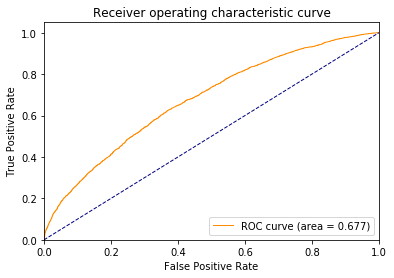

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

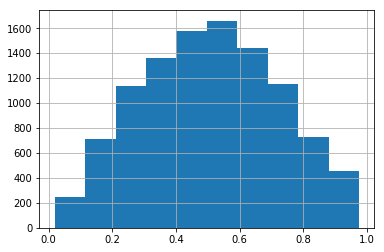

In [23]:
pd.Series(y_test_pred).hist()
plt.show()

In [24]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,184,0.869565
0.1,0.2,680,0.769118
0.2,0.3,1164,0.682990
0.3,0.4,1410,0.601418
0.4,0.5,1720,0.531977
0.5,0.6,1652,0.541162
0.6,0.7,1477,0.582938
0.7,0.8,1140,0.643860
0.8,0.9,705,0.760284


In [25]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrpl_model_201907101744.joblib']